# About the Dataset

### This is a bank credit related dataset collected from PML 2401 course instructor Mr. Sojib Saha

In [2]:
#!pip install xgboost --no-cache-dir

In [3]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler 
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from collections import defaultdict
import pickle # Import pickle for saving and loading models

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Load Data 
print("Loading datasets...")
try:
    df_train = pd.read_csv('train.csv')
    df_test = pd.read_csv('test.csv')
    print("Datasets loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading files: {e}. Make sure 'train.csv' and 'test.csv' are in the same directory.")
    # Exit - handle the error if files are not found
    exit()

Loading datasets...
Datasets loaded successfully.


In [6]:
df_train.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [7]:
# Initial Inspection
print("\n--- Initial Inspection: train.csv ---")
print(f"Shape: {df_train.shape}")
print("\nInfo:")
df_train.info()
print("\nMissing Values:")
print(df_train.isna().sum())
print(f"\nDuplicate Rows: {df_train.duplicated().sum()}")

print("\n--- Initial Inspection: test.csv ---")
print(f"Shape: {df_test.shape}")
print("\nInfo:")
df_test.info()
print("\nMissing Values:")
print(df_test.isna().sum())
print(f"\nDuplicate Rows: {df_test.duplicated().sum()}")


--- Initial Inspection: train.csv ---
Shape: (100000, 28)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 no

In [8]:
# Merge DataFrames
print("\nMerging train and test datasets...")
df_train['source'] = 'train'
df_test['source'] = 'test'
df_merged = pd.concat([df_train, df_test], ignore_index=True)
print(f"Merged dataset shape: {df_merged.shape}")
print(f"Counts from sources: {df_merged['source'].value_counts()}")


Merging train and test datasets...
Merged dataset shape: (150000, 29)
Counts from sources: source
train    100000
test      50000
Name: count, dtype: int64


# Data Cleansing

In [9]:
# Directly Drop Irrelevant Columns 
cols_to_drop_direct = ['ID', 'Customer_ID', 'SSN', 'Name', 'Type_of_Loan']
df_merged = df_merged.drop(columns=cols_to_drop_direct, errors='ignore')
print(f"\nDropped irrelevant columns. New shape: {df_merged.shape}")


Dropped irrelevant columns. New shape: (150000, 24)


In [10]:
# Replace '_' with NaN for consistency in missing value handling
print("\nReplacing '_' with NaN in relevant columns...")

for col in df_merged.select_dtypes(include='object').columns:
    if '_' in df_merged[col].unique(): # Check if '_' is actually present
        df_merged[col] = df_merged[col].replace('_', np.nan)
print("Replacement complete.")


Replacing '_' with NaN in relevant columns...
Replacement complete.


In [11]:
# Drop rows with too many missing values (more than 50% missing)
missing_threshold = 0.5 * df_merged.shape[1]
initial_rows = df_merged.shape[0]
df_merged.dropna(thresh=missing_threshold, inplace=True)
rows_dropped_missing = initial_rows - df_merged.shape[0]
print(f"Dropped {rows_dropped_missing} rows with more than 50% missing values. New shape: {df_merged.shape}")

Dropped 0 rows with more than 50% missing values. New shape: (150000, 24)


In [12]:
print("\nImputing remaining missing values...")
# Separate numerical and categorical columns for imputation
numerical_cols = df_merged.select_dtypes(include=np.number).columns
categorical_cols = df_merged.select_dtypes(include='object').columns

# Impute numerical missing values with the median
for col in numerical_cols:
    if df_merged[col].isnull().any():
        median_val = df_merged[col].median()
        df_merged[col].fillna(median_val, inplace=True)
        print(f"  - Imputed numerical column '{col}' with median: {median_val}")

# Impute categorical missing values with the mode
for col in categorical_cols:
    if df_merged[col].isnull().any():
        # Mode might return multiple values, pick the first one
        mode_val = df_merged[col].mode()[0]
        df_merged[col].fillna(mode_val, inplace=True)
        print(f"  - Imputed categorical column '{col}' with mode: {mode_val}")

print("Missing value imputation complete.")


Imputing remaining missing values...
  - Imputed numerical column 'Monthly_Inhand_Salary' with median: 3091.0
  - Imputed numerical column 'Num_Credit_Inquiries' with median: 6.0
  - Imputed categorical column 'Num_of_Delayed_Payment' with mode: 19
  - Imputed categorical column 'Changed_Credit_Limit' with mode: 11.5
  - Imputed categorical column 'Credit_Mix' with mode: Standard
  - Imputed categorical column 'Credit_History_Age' with mode: 17 Years and 11 Months
  - Imputed categorical column 'Amount_invested_monthly' with mode: __10000__
  - Imputed categorical column 'Monthly_Balance' with mode: __-333333333333333333333333333__
  - Imputed categorical column 'Credit_Score' with mode: Standard
Missing value imputation complete.


# Preprocessing

In [13]:
# Feature Engineering for Credit_History_Age
print("\nProcessing 'Credit_History_Age'...")
def convert_credit_history_age_to_months(age_str):
    if pd.isna(age_str):
        return np.nan # Keeping NaN for later imputation if needed
    # Regex to capture years and optional months
    match = re.match(r'(\d+)\s+Years(?:\s+and\s+(\d+)\s+Months)?', str(age_str))
    if match:
        years = int(match.group(1))
        months = int(match.group(2)) if match.group(2) else 0
        return (years * 12) + months
    return np.nan # Return NaN if format doesn't match

df_merged['Credit_History_Age_Months'] = df_merged['Credit_History_Age'].apply(convert_credit_history_age_to_months)
# Drop original column
df_merged = df_merged.drop(columns=['Credit_History_Age'])
# Impute any NaNs that might have been created by regex if original column had bad format or NaNs persisted
if df_merged['Credit_History_Age_Months'].isnull().any():
    median_age_months = df_merged['Credit_History_Age_Months'].median()
    df_merged['Credit_History_Age_Months'].fillna(median_age_months, inplace=True)
    print(f"  - Imputed 'Credit_History_Age_Months' with median: {median_age_months}")
print("'Credit_History_Age' converted to numerical months.")


Processing 'Credit_History_Age'...
'Credit_History_Age' converted to numerical months.


In [14]:
# Ordinal Encoding for target 'Credit_Score'
print("\nEncoding target 'Credit_Score'...")
# Define the explicit mapping for ordinality
credit_score_mapping = {'Poor': 0, 'Standard': 1, 'Good': 2}
df_merged['Credit_Score'] = df_merged['Credit_Score'].map(credit_score_mapping)
# Handle any potential remaining NaNs in 'Credit_Score' if original data had issues
if df_merged['Credit_Score'].isnull().any():
    initial_target_rows = df_merged.shape[0]
    df_merged.dropna(subset=['Credit_Score'], inplace=True)
    dropped_target_rows = initial_target_rows - df_merged.shape[0]
    print(f"  - Dropped {dropped_target_rows} rows due to NaN in 'Credit_Score' after mapping.")
print("'Credit_Score' encoded to numerical values (Poor=0, Standard=1, Good=2).")


Encoding target 'Credit_Score'...
'Credit_Score' encoded to numerical values (Poor=0, Standard=1, Good=2).


In [15]:
# Ordinal Encoding for 'Credit_Mix'
print("\nEncoding 'Credit_Mix'...")
credit_mix_mapping = {'Bad': 0, 'Standard': 1, 'Good': 2}
df_merged['Credit_Mix'] = df_merged['Credit_Mix'].map(credit_mix_mapping)
# Impute any NaNs that might have been created by mapping if original column had unmapped values
if df_merged['Credit_Mix'].isnull().any():
    mode_credit_mix = df_merged['Credit_Mix'].mode()[0]
    df_merged['Credit_Mix'].fillna(mode_credit_mix, inplace=True)
    print(f"  - Imputed 'Credit_Mix' with mode: {mode_credit_mix}")
print("'Credit_Mix' encoded to numerical values (Bad=0, Standard=1, Good=2).")


Encoding 'Credit_Mix'...
'Credit_Mix' encoded to numerical values (Bad=0, Standard=1, Good=2).


In [16]:
# Binary Encoding for 'Payment_of_Min_Amount'
print("\nEncoding 'Payment_of_Min_Amount'...")
payment_min_mapping = {'No': 0, 'Yes': 1}
df_merged['Payment_of_Min_Amount'] = df_merged['Payment_of_Min_Amount'].map(payment_min_mapping)
# Impute any NaNs that might have been created by mapping if original column had unmapped values
if df_merged['Payment_of_Min_Amount'].isnull().any():
    mode_payment_min = df_merged['Payment_of_Min_Amount'].mode()[0]
    df_merged['Payment_of_Min_Amount'].fillna(mode_payment_min, inplace=True)
    print(f"  - Imputed 'Payment_of_Min_Amount' with mode: {mode_payment_min}")
print("'Payment_of_Min_Amount' encoded to numerical values (No=0, Yes=1).")


Encoding 'Payment_of_Min_Amount'...
  - Imputed 'Payment_of_Min_Amount' with mode: 1.0
'Payment_of_Min_Amount' encoded to numerical values (No=0, Yes=1).


In [17]:
# Ordinal Encoding for remaining nominal categorical columns
cols_for_ordinal_encoding = [
    'Month',
    'Occupation',
    'Payment_Behaviour'
]

print(f"\nApplying Ordinal Encoding to: {cols_for_ordinal_encoding}...")
label_encoder = LabelEncoder()
for col in cols_for_ordinal_encoding:
    # Handle potential NaNs before encoding by filling with a placeholder or mode
    if df_merged[col].isnull().any():
        df_merged[col].fillna(df_merged[col].mode()[0], inplace=True)
        print(f"  - Imputed NaNs in '{col}' before encoding with mode.")
    df_merged[col] = label_encoder.fit_transform(df_merged[col])
    print(f"  - Column '{col}' encoded with {len(label_encoder.classes_)} unique values.")
print("Ordinal Encoding complete.")
print(f"New shape after ordinal encoding: {df_merged.shape}")


Applying Ordinal Encoding to: ['Month', 'Occupation', 'Payment_Behaviour']...
  - Column 'Month' encoded with 12 unique values.
  - Column 'Occupation' encoded with 16 unique values.
  - Column 'Payment_Behaviour' encoded with 7 unique values.
Ordinal Encoding complete.
New shape after ordinal encoding: (150000, 24)


In [18]:
# Final check of data types and missing values 
print("\n--- Final Data Inspection ---")
print(f"Final merged dataset shape: {df_merged.shape}")
print("\nFinal Missing Values Check:")
print(df_merged.isna().sum().sum()) # Should be 0 if all handled
if df_merged.isna().sum().sum() > 0:
    print("WARNING: Some missing values still exist. Please re-check imputation steps.")
else:
    print("No missing values found.")


--- Final Data Inspection ---
Final merged dataset shape: (150000, 24)

Final Missing Values Check:
0
No missing values found.


In [19]:
print("\nSample of preprocessed data:")
df_merged.head()


Sample of preprocessed data:


,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,...,Outstanding_Debt,Credit_Utilization_Ratio,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,source,Credit_History_Age_Months
0,4,23,12,19114.12,1824.843333,3,4,3,4,3,...,809.98,26.822620,0.0,49.574949,80.41529543900253,3,312.49408867943663,2,train,265
1,3,23,12,19114.12,3091.000000,3,4,3,4,-1,...,809.98,31.944960,0.0,49.574949,118.28022162236736,4,284.62916249607184,2,train,215
2,7,-500,12,19114.12,3091.000000,3,4,3,4,3,...,809.98,28.609352,0.0,49.574949,81.699521264648,5,331.2098628537912,2,train,267
3,0,23,12,19114.12,3091.000000,3,4,3,4,5,...,809.98,31.377862,0.0,49.574949,199.4580743910713,6,223.45130972736786,2,train,268
4,8,23,12,19114.12,1824.843333,3,4,3,4,6,...,809.98,24.797347,0.0,49.574949,41.420153086217326,2,341.48923103222177,2,train,269


In [20]:
# Save Cleaned Dataset
output_filename = 'clean_Bank_Loan.csv'
df_merged.to_csv(output_filename, index=False)
print(f"\nCleaned and preprocessed data saved to '{output_filename}'.")


Cleaned and preprocessed data saved to 'clean_Bank_Loan.csv'.


# Exploratory Data Analysis (EDA)

In [21]:
# Set plot style for better aesthetics
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

In [22]:
# Load the Cleaned Dataset 
print("Loading 'clean_Bank_Loan.csv' for EDA and Visualization...")
try:
    df_clean = pd.read_csv('clean_Bank_Loan.csv')
    print("Cleaned dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'clean_Bank_Loan.csv' not found. Please ensure the preprocessing script was run successfully.")
    exit()

Loading 'clean_Bank_Loan.csv' for EDA and Visualization...
Cleaned dataset loaded successfully.


In [23]:
print(f"\nShape of the cleaned dataset: {df_clean.shape}")
print("\nFirst 5 rows of the cleaned dataset:")
df_clean.head()


Shape of the cleaned dataset: (150000, 24)

First 5 rows of the cleaned dataset:


,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,...,Outstanding_Debt,Credit_Utilization_Ratio,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,source,Credit_History_Age_Months
0,4,23,12,19114.12,1824.843333,3,4,3,4,3,...,809.98,26.822620,0.0,49.574949,80.41529543900253,3,312.49408867943663,2,train,265
1,3,23,12,19114.12,3091.000000,3,4,3,4,-1,...,809.98,31.944960,0.0,49.574949,118.28022162236736,4,284.62916249607184,2,train,215
2,7,-500,12,19114.12,3091.000000,3,4,3,4,3,...,809.98,28.609352,0.0,49.574949,81.699521264648,5,331.2098628537912,2,train,267
3,0,23,12,19114.12,3091.000000,3,4,3,4,5,...,809.98,31.377862,0.0,49.574949,199.4580743910713,6,223.45130972736786,2,train,268
4,8,23,12,19114.12,1824.843333,3,4,3,4,6,...,809.98,24.797347,0.0,49.574949,41.420153086217326,2,341.48923103222177,2,train,269


In [24]:
# Split Data Back into Training and Test Sets 
print("\nSplitting data back into training and test sets...")
df_train_eda = df_clean[df_clean['source'] == 'train'].copy()
df_test_eda = df_clean[df_clean['source'] == 'test'].copy()


Splitting data back into training and test sets...


In [25]:
# Drop the 'source' column as it's no longer needed for features
df_train_eda = df_train_eda.drop(columns=['source'])
df_test_eda = df_test_eda.drop(columns=['source'])

In [26]:
# Separate features (X) and target (y) for the training set
X_train_eda = df_train_eda.drop(columns=['Credit_Score'])
y_train_eda = df_train_eda['Credit_Score']

In [27]:
print(f"X_train_eda shape: {X_train_eda.shape}")
print(f"y_train_eda shape: {y_train_eda.shape}")
print(f"df_test_eda shape: {df_test_eda.shape}")

X_train_eda shape: (100000, 22)
y_train_eda shape: (100000,)
df_test_eda shape: (50000, 23)


# Exploratory Data Analysis (EDA) on X_train_eda and y_train_eda

In [28]:
print("\n--- Performing EDA on Training Data ---")

# Check the distribution of the target variable (Credit_Score)
print("\nDistribution of 'Credit_Score' (Target Variable):")
credit_score_counts = y_train_eda.value_counts(normalize=True) * 100
print(credit_score_counts)


--- Performing EDA on Training Data ---

Distribution of 'Credit_Score' (Target Variable):
Credit_Score
1    53.174
0    28.998
2    17.828
Name: proportion, dtype: float64


In [29]:
# Map numerical labels back to original for better readability in plots
credit_score_labels = {0: 'Poor', 1: 'Standard', 2: 'Good'}
y_train_eda_labels = y_train_eda.map(credit_score_labels)

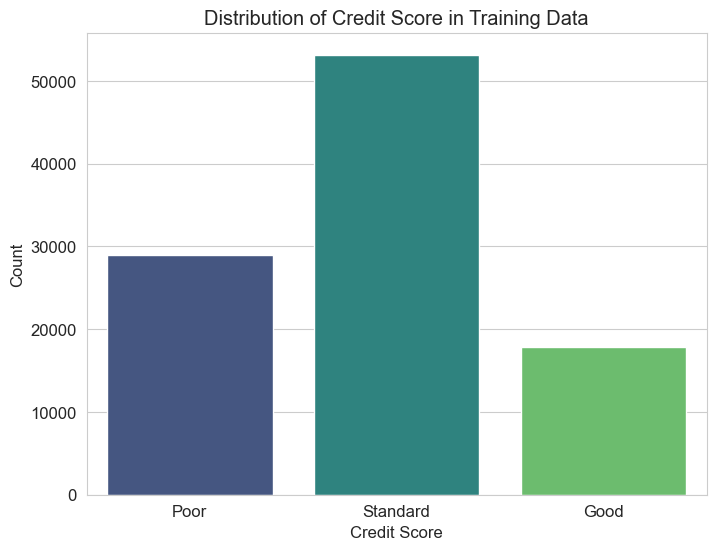

In [30]:
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_eda_labels, palette='viridis', order=['Poor', 'Standard', 'Good'])
plt.title('Distribution of Credit Score in Training Data')
plt.xlabel('Credit Score')
plt.ylabel('Count')
plt.show()

In [31]:
# Identify numerical and categorical columns (after preprocessing)
numerical_cols = X_train_eda.select_dtypes(include=np.number).columns
categorical_cols = X_train_eda.select_dtypes(include=['object', 'bool']).columns # Check for any lingering object or bool types

print(f"\nIdentified {len(numerical_cols)} numerical columns.")
print(f"Identified {len(categorical_cols)} categorical columns (post-encoding).")


Identified 15 numerical columns.
Identified 7 categorical columns (post-encoding).


# Data Visualization



Generating Histograms for Numerical Features...


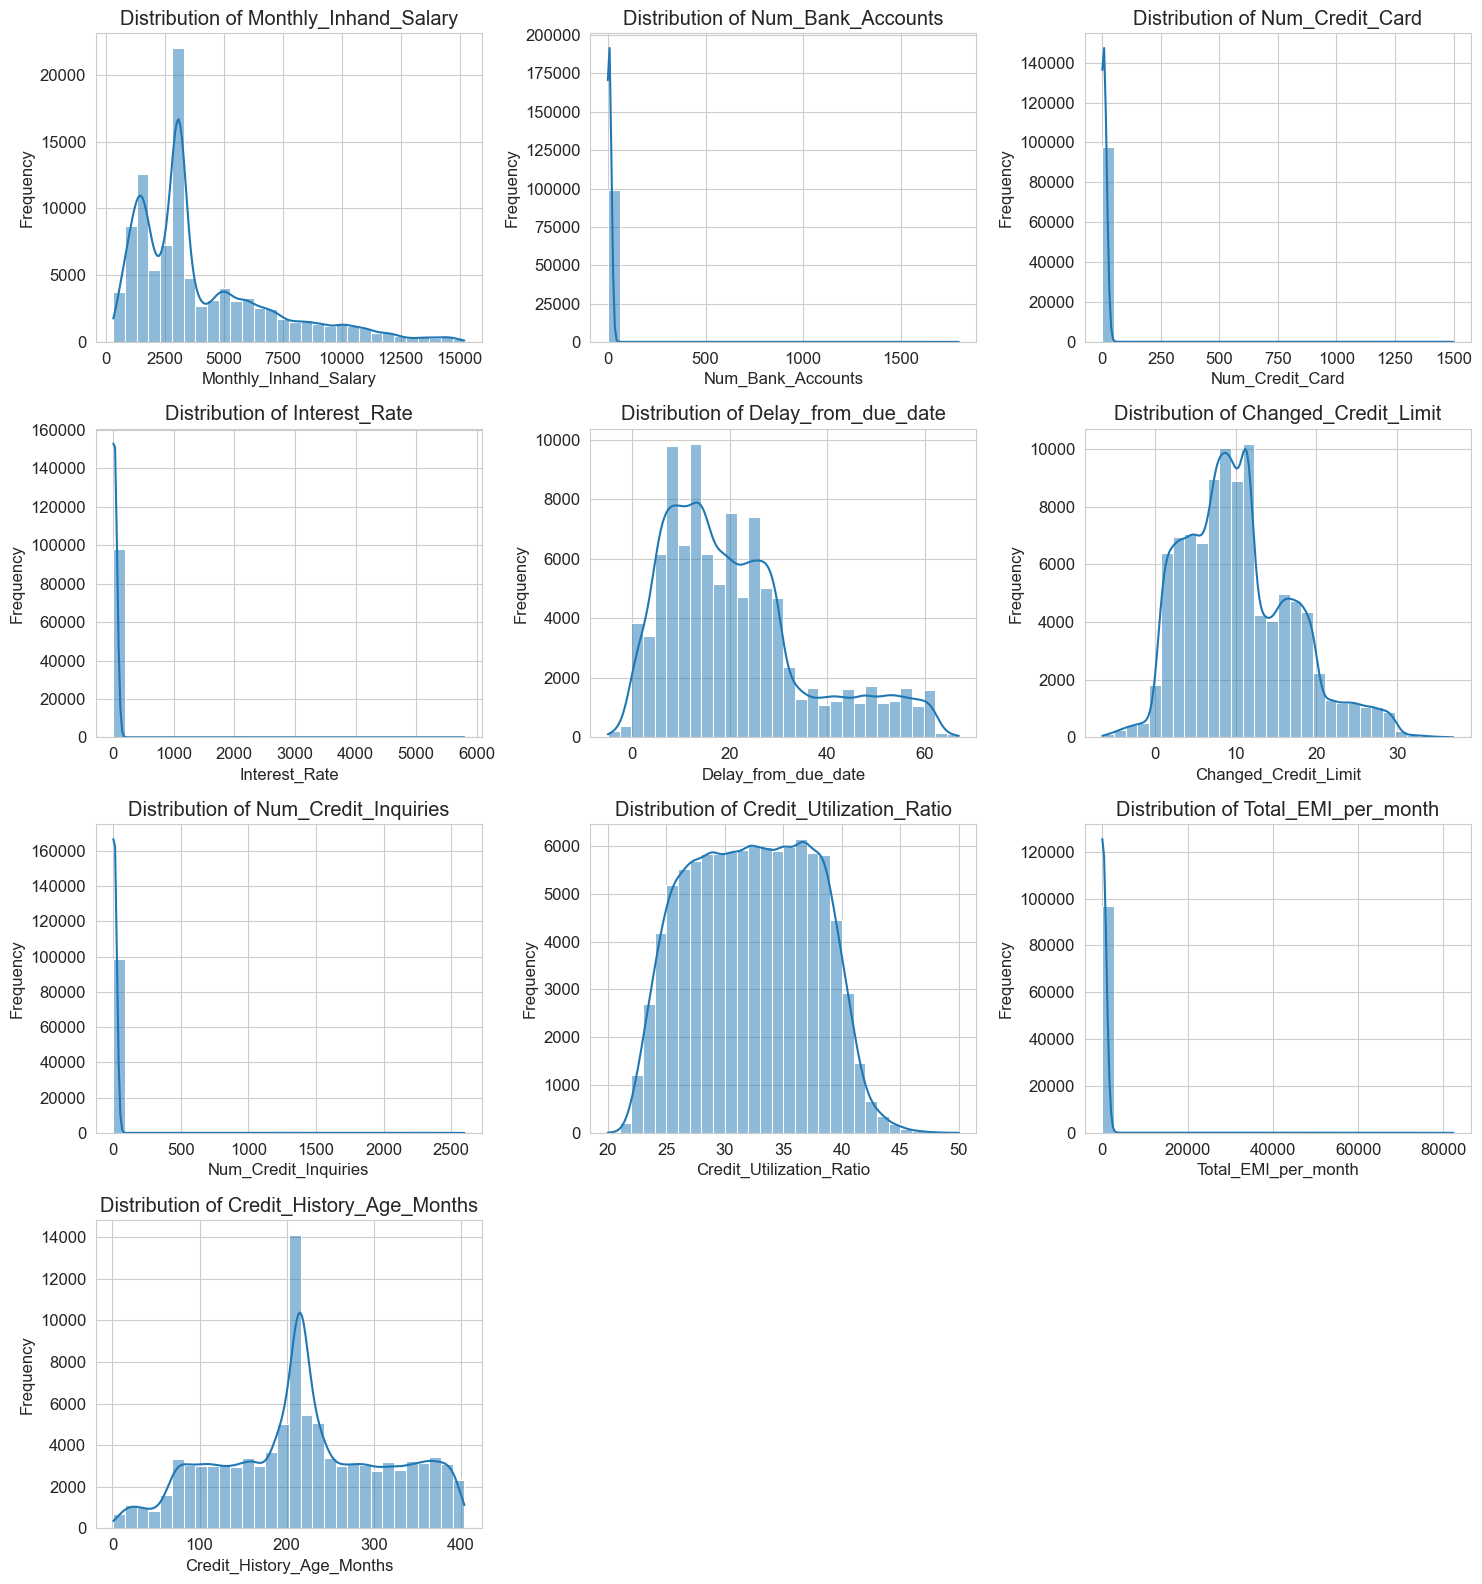

In [32]:
# Distribution of Numerical Features (Histograms)
print("\nGenerating Histograms for Numerical Features...")

numerical_features_to_plot = [
    'Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
    'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
    'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
    'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Total_EMI_per_month',
    'Amount_invested_monthly', 'Monthly_Balance', 'Credit_History_Age_Months'
]
# Filter to only existing columns
numerical_features_to_plot = [col for col in numerical_features_to_plot if col in numerical_cols]

if len(numerical_features_to_plot) > 0:
    num_plots = len(numerical_features_to_plot)
    num_cols = 3
    num_rows = (num_plots + num_cols - 1) // num_cols # Ceiling division
    plt.figure(figsize=(num_cols * 5, num_rows * 4))
    for i, col in enumerate(numerical_features_to_plot):
        plt.subplot(num_rows, num_cols, i + 1)
        sns.histplot(X_train_eda[col], kde=True, bins=30)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
else:
    print("No numerical columns found to plot histograms.")


Generating Box Plots for Numerical Features vs. Credit Score...


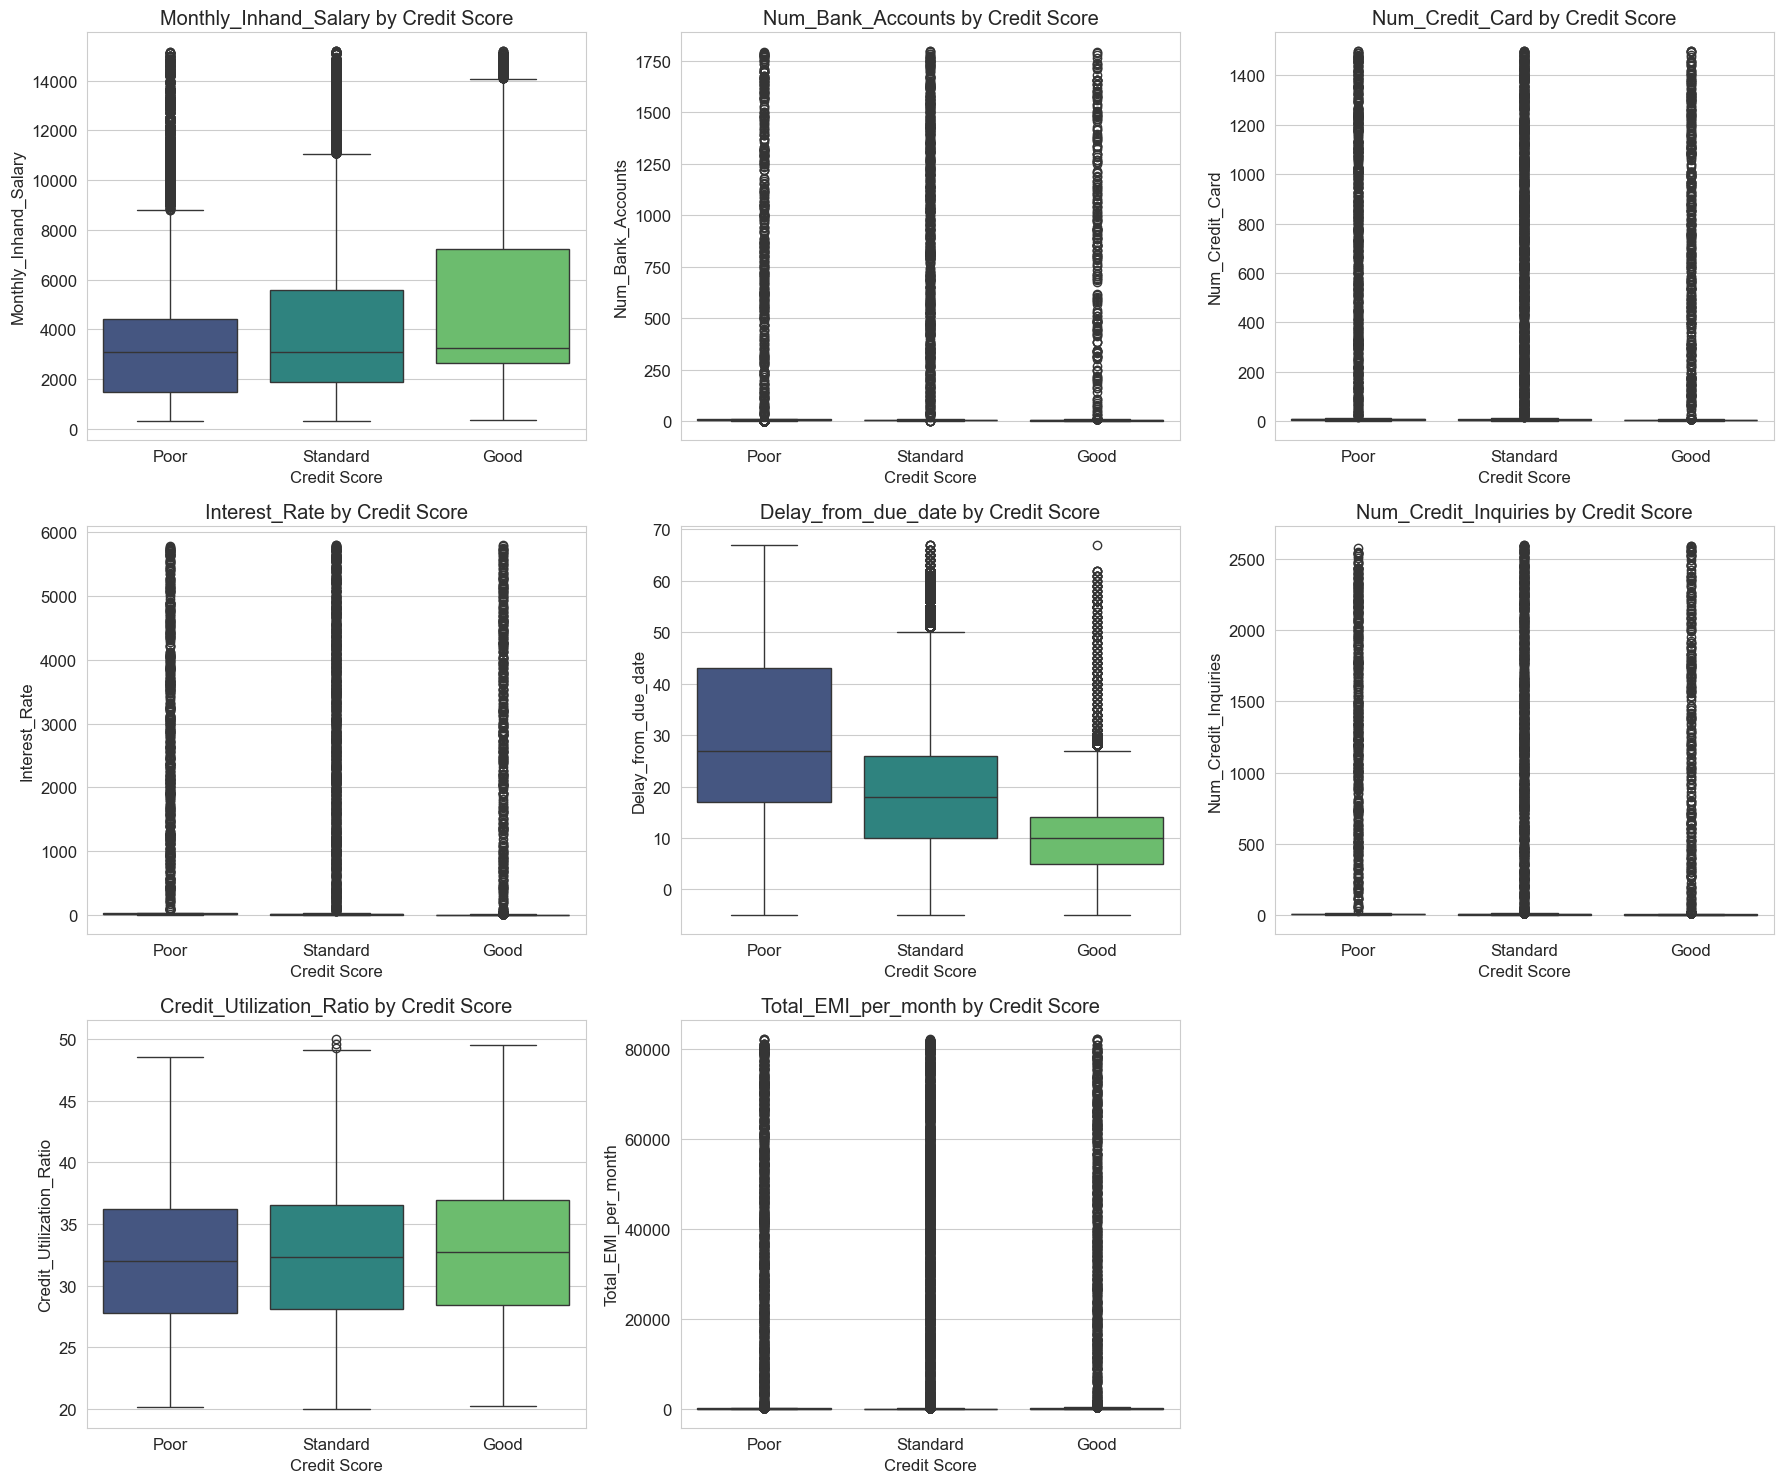

In [32]:
# Box Plots for Numerical Features vs. Target (Credit_Score)
print("\nGenerating Box Plots for Numerical Features vs. Credit Score...")
if len(numerical_features_to_plot) > 0:
    num_plots = len(numerical_features_to_plot)
    num_cols = 3
    num_rows = (num_plots + num_cols - 1) // num_cols
    plt.figure(figsize=(num_cols * 6, num_rows * 5))
    for i, col in enumerate(numerical_features_to_plot):
        plt.subplot(num_rows, num_cols, i + 1)
        sns.boxplot(x=y_train_eda_labels, y=X_train_eda[col], palette='viridis', order=['Poor', 'Standard', 'Good'])
        plt.title(f'{col} by Credit Score')
        plt.xlabel('Credit Score')
        plt.ylabel(col)
    plt.tight_layout()
    plt.show()
else:
    print("No numerical columns found to plot box plots against target.")


Generating Count Plots for Ordinal Encoded Categorical Features...


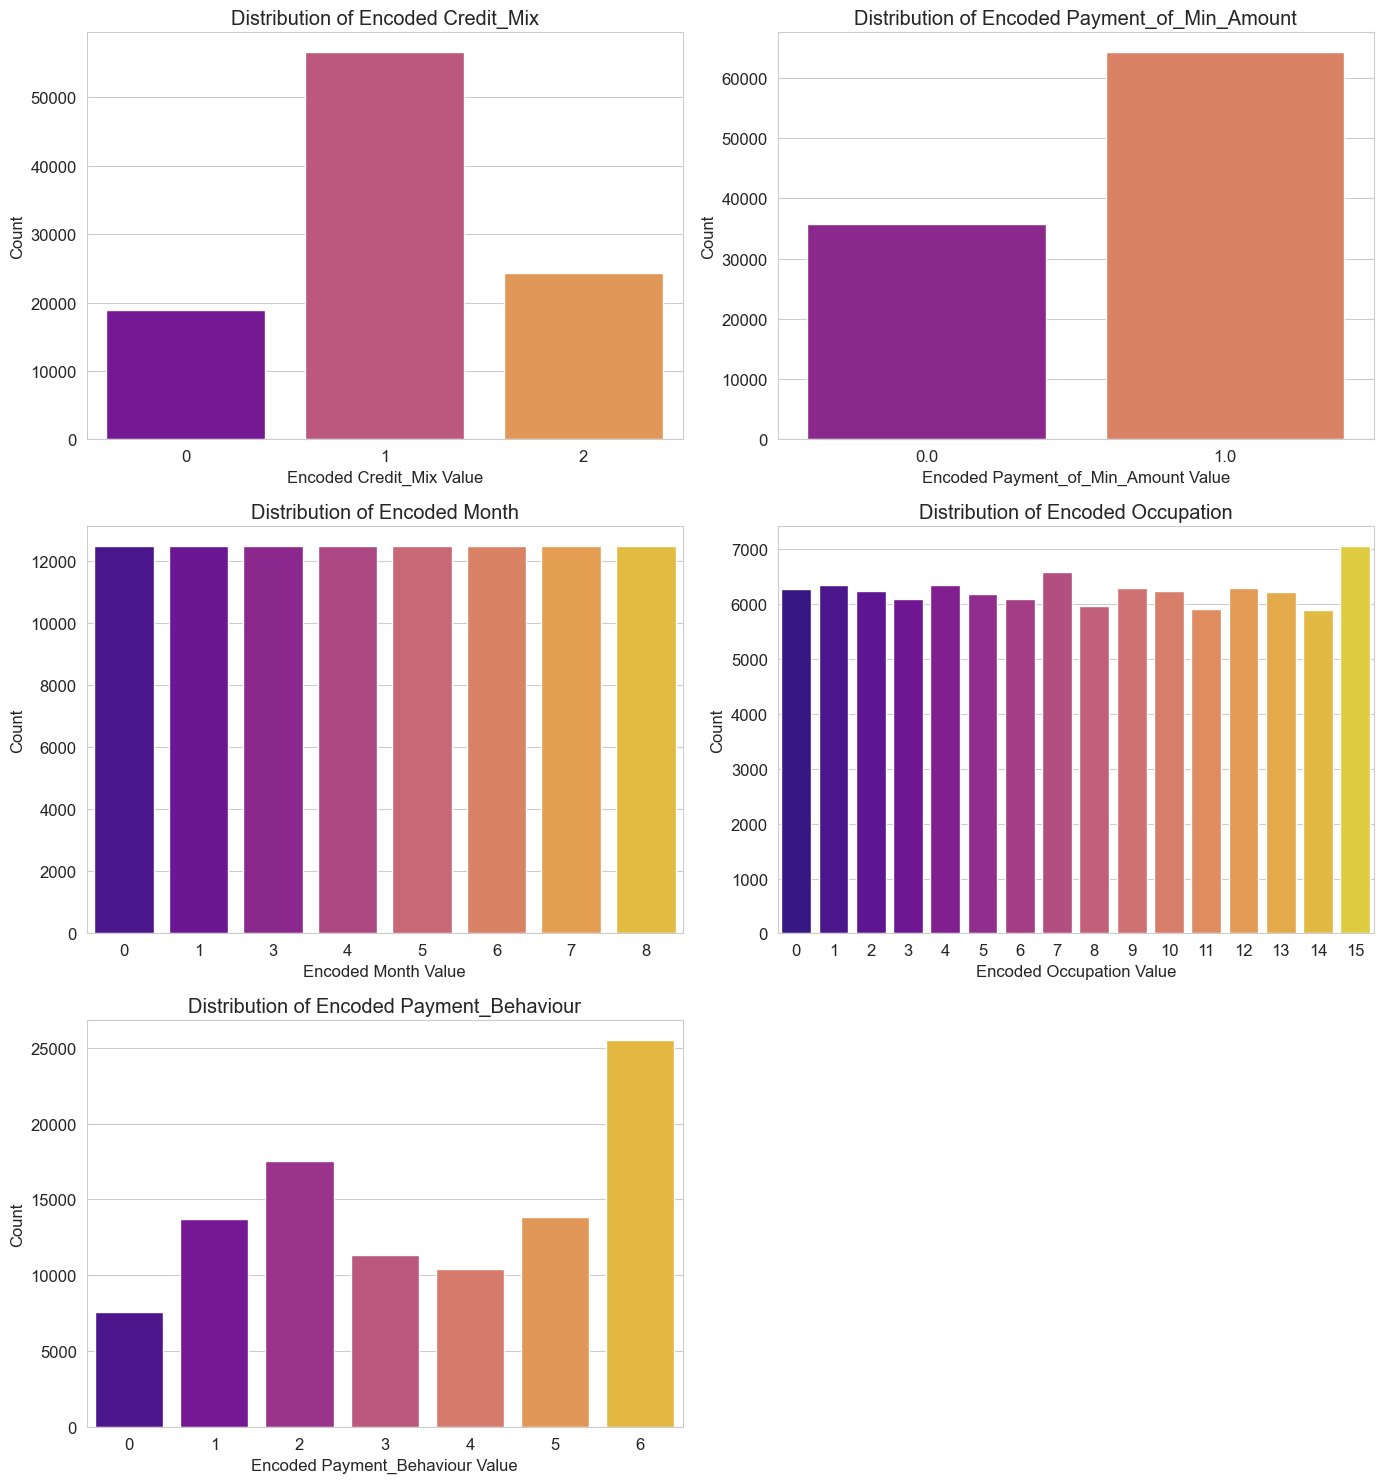

In [33]:
# Distribution of Categorical Features (Count Plots)
print("\nGenerating Count Plots for Ordinal Encoded Categorical Features...")
# Identify ordinal encoded columns from the preprocessing step
ordinal_encoded_cols = [
    'Credit_Mix',
    'Payment_of_Min_Amount',
    'Month',
    'Occupation',
    'Payment_Behaviour'
]
# Filter to only existing columns and ensure they are numerical after encoding
ordinal_encoded_cols_existing = [col for col in ordinal_encoded_cols if col in X_train_eda.columns and pd.api.types.is_numeric_dtype(X_train_eda[col])]

if len(ordinal_encoded_cols_existing) > 0:
    num_plots = len(ordinal_encoded_cols_existing)
    num_cols = 2
    num_rows = (num_plots + num_cols - 1) // num_cols
    plt.figure(figsize=(num_cols * 7, num_rows * 5))
    for i, col in enumerate(ordinal_encoded_cols_existing):
        plt.subplot(num_rows, num_cols, i + 1)
        sns.countplot(x=X_train_eda[col], palette='plasma')
        plt.title(f'Distribution of Encoded {col}')
        plt.xlabel(f'Encoded {col} Value')
        plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
else:
    print("No ordinal encoded categorical columns found to plot count plots.")


Generating Correlation Matrix for Numerical Features...


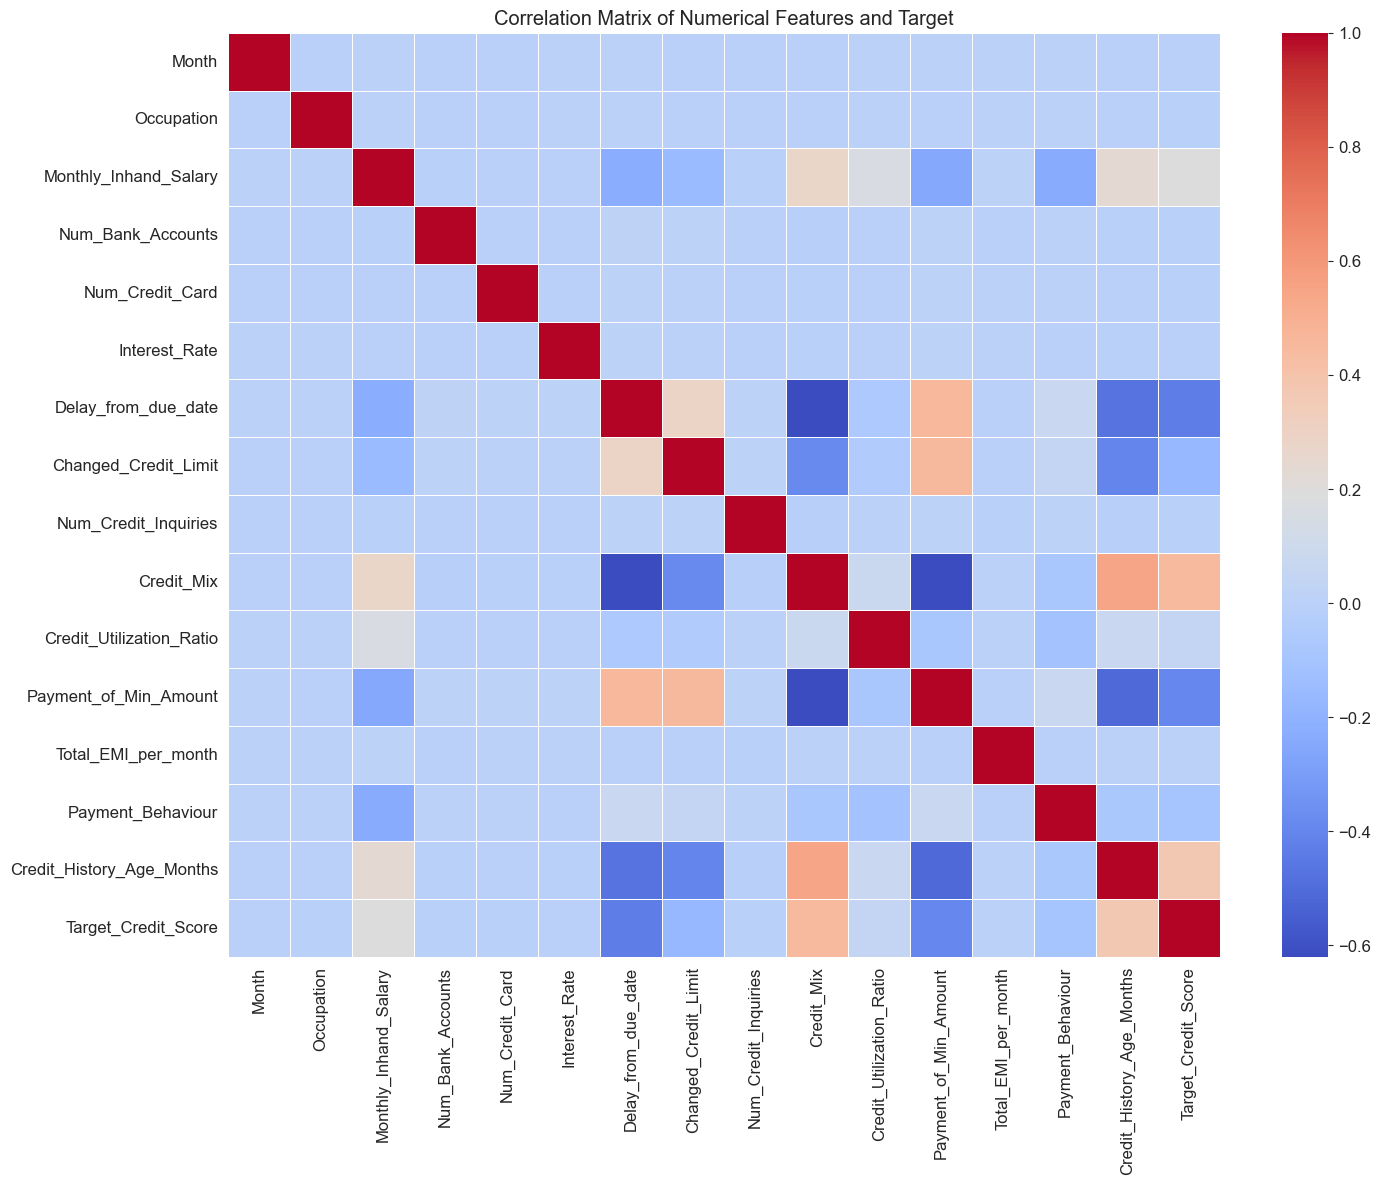

In [34]:
# Correlation Matrix for Numerical Features
print("\nGenerating Correlation Matrix for Numerical Features...")
if len(numerical_cols) > 1:
    plt.figure(figsize=(16, 12))
    # Combine numerical features with the target for correlation
    df_corr = pd.concat([X_train_eda[numerical_cols], y_train_eda], axis=1)
    # Rename target column for correlation matrix clarity
    df_corr = df_corr.rename(columns={'Credit_Score': 'Target_Credit_Score'})

    correlation_matrix = df_corr.corr()
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Matrix of Numerical Features and Target')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()
else:
    print("Not enough numerical columns to generate a correlation matrix.")

# Model Training and Evaluation

In [35]:
# Load the Cleaned Dataset
print("Loading 'clean_Bank_Loan.csv' for model training and evaluation...")
try:
    df_clean = pd.read_csv('clean_Bank_Loan.csv')
    print("Cleaned dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'clean_Bank_Loan.csv' not found. Please ensure the preprocessing script was run successfully.")
    exit()

Loading 'clean_Bank_Loan.csv' for model training and evaluation...
Cleaned dataset loaded successfully.


In [36]:
print(f"\nShape of the cleaned dataset: {df_clean.shape}")
print("\nFirst 5 rows of the cleaned dataset (showing preprocessed state):")
df_clean.head()


Shape of the cleaned dataset: (150000, 24)

First 5 rows of the cleaned dataset (showing preprocessed state):


,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,...,Outstanding_Debt,Credit_Utilization_Ratio,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,source,Credit_History_Age_Months
0,4,23,12,19114.12,1824.843333,3,4,3,4,3,...,809.98,26.822620,0.0,49.574949,80.41529543900253,3,312.49408867943663,2,train,265
1,3,23,12,19114.12,3091.000000,3,4,3,4,-1,...,809.98,31.944960,0.0,49.574949,118.28022162236736,4,284.62916249607184,2,train,215
2,7,-500,12,19114.12,3091.000000,3,4,3,4,3,...,809.98,28.609352,0.0,49.574949,81.699521264648,5,331.2098628537912,2,train,267
3,0,23,12,19114.12,3091.000000,3,4,3,4,5,...,809.98,31.377862,0.0,49.574949,199.4580743910713,6,223.45130972736786,2,train,268
4,8,23,12,19114.12,1824.843333,3,4,3,4,6,...,809.98,24.797347,0.0,49.574949,41.420153086217326,2,341.48923103222177,2,train,269


In [37]:
# Split Data Back into Training and Test Sets 
print("\nSplitting data back into original train and test sets...")
df_train_original = df_clean[df_clean['source'] == 'train'].copy()
df_test_original = df_clean[df_clean['source'] == 'test'].copy()


Splitting data back into original train and test sets...


In [38]:
# Drop the 'source' column
df_train_original.drop(columns=['source'], inplace=True)
df_test_original.drop(columns=['source'], inplace=True)

In [39]:
# Separate features (X) and target (y)
X_train = df_train_original.drop(columns=['Credit_Score'])
y_train = df_train_original['Credit_Score']
X_test = df_test_original.drop(columns=['Credit_Score'], errors='ignore') # Test set might not have 'Credit_Score'
y_test = df_clean[df_clean['source'] == 'test']['Credit_Score'] # Define y_test here for evaluation

In [40]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (100000, 22)
y_train shape: (100000,)
X_test shape: (50000, 22)
y_test shape: (50000,)


# Robust Numerical Conversion and Re-Imputation

In [41]:
# This step handles any numerical columns that might still contain non-numeric strings
# after initial preprocessing, converting them to numeric and imputing any new NaNs.
numerical_features_for_robust_conversion = [
    'Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
    'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
    'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
    'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Total_EMI_per_month',
    'Amount_invested_monthly', 'Monthly_Balance', 'Credit_History_Age_Months'
]

print("\nPerforming robust numerical conversion on potential non-numeric numerical columns...")

for col in numerical_features_for_robust_conversion:
    if col in X_train.columns: # Ensure column exists in X_train
        # Convert to numeric, coercing errors to NaN
        X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
        X_test[col] = pd.to_numeric(X_test[col], errors='coerce') # Apply to test set too

# After coercing, there might be new NaNs. Impute them again with median (from training data) as a critical safeguard.

print("Imputing any NaNs introduced by robust numerical conversion...")
for col in numerical_features_for_robust_conversion:
    if col in X_train.columns:
        if X_train[col].isnull().any():
            median_val = X_train[col].median()
            X_train[col].fillna(median_val, inplace=True)
            X_test[col].fillna(median_val, inplace=True) # Use training median for test set
            print(f"  - Imputed new NaNs in '{col}' with median: {median_val}")
            
print("Robust numerical conversion and imputation complete.")


Performing robust numerical conversion on potential non-numeric numerical columns...
Imputing any NaNs introduced by robust numerical conversion...
  - Imputed new NaNs in 'Age' with median: 33.0
  - Imputed new NaNs in 'Annual_Income' with median: 37550.74
  - Imputed new NaNs in 'Num_of_Loan' with median: 3.0
  - Imputed new NaNs in 'Num_of_Delayed_Payment' with median: 15.0
  - Imputed new NaNs in 'Outstanding_Debt' with median: 1166.37
  - Imputed new NaNs in 'Amount_invested_monthly' with median: 128.95453805190283
  - Imputed new NaNs in 'Monthly_Balance' with median: 336.73122455696387
Robust numerical conversion and imputation complete.


# Standard Scaling

In [42]:
numerical_cols_for_scaling = X_train.select_dtypes(include=np.number).columns.tolist()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numerical_cols_for_scaling])
X_test_scaled = scaler.transform(X_test[numerical_cols_for_scaling])

# Convert back to DataFrame, preserving column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=numerical_cols_for_scaling, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=numerical_cols_for_scaling, index=X_test.index)

# Replace original numerical columns with scaled ones
X_train[numerical_cols_for_scaling] = X_train_scaled
X_test[numerical_cols_for_scaling] = X_test_scaled

print("Standard Scaling complete.")
# Save the scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("X_train (scaled) head:\n")
X_train.head()

Standard Scaling complete.
X_train (scaled) head:



,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,...,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_History_Age_Months
0,-0.094916,-0.125057,0.964732,-0.107481,-0.744165,-0.120024,-0.14315,-0.148934,0.019826,-1.215932,...,-0.121943,-0.081518,-0.534061,-1.067562,-1.343023,-0.16296,-0.570549,-0.230434,-0.419562,0.466266
1,-0.474579,-0.125057,0.964732,-0.107481,-0.316623,-0.120024,-0.14315,-0.148934,0.019826,-1.485110,...,-0.121943,1.442759,-0.534061,-0.066489,-1.343023,-0.16296,-0.372848,0.260855,-0.550538,-0.059234
2,1.044074,-0.902896,0.964732,-0.107481,-0.316623,-0.120024,-0.14315,-0.148934,0.019826,-1.215932,...,-0.121943,1.442759,-0.534061,-0.718376,-1.343023,-0.16296,-0.563843,0.752144,-0.331591,0.487286
3,-1.613569,-0.125057,0.964732,-0.107481,-0.316623,-0.120024,-0.14315,-0.148934,0.019826,-1.081342,...,-0.121943,1.442759,-0.534061,-0.177318,-1.343023,-0.16296,0.050998,1.243433,-0.838097,0.497796
4,1.423737,-0.125057,0.964732,-0.107481,-0.744165,-0.120024,-0.14315,-0.148934,0.019826,-1.014048,...,-0.121943,1.442759,-0.534061,-1.463366,-1.343023,-0.16296,-0.774150,-0.721723,-0.283274,0.508306


# Handle Class Imbalance with SMOTE

In [44]:
print("\nHandling class imbalance using SMOTE on training data...")
print(f"Original 'Credit_Score' distribution in training data:\n{y_train.value_counts()}")


Handling class imbalance using SMOTE on training data...
Original 'Credit_Score' distribution in training data:
Credit_Score
1    53174
0    28998
2    17828
Name: count, dtype: int64


In [45]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [46]:
print(f"\nResampled 'Credit_Score' distribution in training data:\n{y_train_res.value_counts()}")
print(f"X_train_res shape: {X_train_res.shape}, y_train_res shape: {y_train_res.shape}")
print("SMOTE resampling complete.")


Resampled 'Credit_Score' distribution in training data:
Credit_Score
2    53174
1    53174
0    53174
Name: count, dtype: int64
X_train_res shape: (159522, 22), y_train_res shape: (159522,)
SMOTE resampling complete.


# Feature Selection (RFE)

In [47]:
print("\nPerforming Feature Selection using RFE...")

n_features_to_select = 20 

rfe_estimator = LogisticRegression(solver='liblinear', random_state=42, max_iter=200)
rfe = RFE(estimator=rfe_estimator, n_features_to_select=n_features_to_select, step=1)

# Fit RFE on the resampled training data
rfe.fit(X_train_res, y_train_res)

# Get selected features
selected_features = X_train_res.columns[rfe.support_].tolist()
print(f"\nSelected {len(selected_features)} features by RFE: {selected_features}")

# Apply feature selection to both resampled training and test data
X_train_selected = X_train_res[selected_features]
X_test_selected = X_test[selected_features] 

print(f"X_train_selected shape: {X_train_selected.shape}")
print(f"X_test_selected shape: {X_test_selected.shape}")
print("Feature selection complete.")


Performing Feature Selection using RFE...

Selected 20 features by RFE: ['Month', 'Age', 'Occupation', 'Annual_Income', 'Monthly_Inhand_Salary', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Payment_of_Min_Amount', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance', 'Credit_History_Age_Months']
X_train_selected shape: (159522, 20)
X_test_selected shape: (50000, 20)
Feature selection complete.


# Model Implementation and Hyperparameter Tuning (Grid Search)

In [46]:
print("\n--- Model Training and Hyperparameter Tuning ---")

# Mapping for Credit Score labels for confusion matrix visualization
credit_score_labels_map = {0: 'Poor', 1: 'Standard', 2: 'Good'}

models = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, solver='saga', multi_class='multinomial'), # 'saga' handles L1/L2 and multinomial
        'params': {
            'C': [0.1, 1, 10],
            'penalty': ['l2'] 
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200], # Number of trees
            'max_depth': [None, 10, 20] # Max depth of trees
        }
    },
    'SVM': {
        'model': SVC(random_state=42, probability=True), 
        'params': {
            'C': [0.1, 1],
            'kernel': ['rbf'] # 'linear' is faster, 'rbf' for non-linearity
        }
    },
    'K-Nearest Neighbors': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7], # Number of neighbors
            'weights': ['uniform', 'distance']
        }
    },
    'XGBoost': {
        'model': xgb.XGBClassifier(objective='multi:softmax', eval_metric='mlogloss', use_label_encoder=False, random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5]
        }
    }
}

best_models = {}
model_accuracies = {} # Dictionary to store model accuracies
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) # Reduced folds for faster computation

best_overall_accuracy = 0.0
best_overall_model_name = None

for model_name, model_info in models.items():
    print(f"\n--- Training and Tuning {model_name} ---")
    grid_search = GridSearchCV(
        estimator=model_info['model'],
        param_grid=model_info['params'],
        cv=cv,
        scoring='accuracy', # Use accuracy for GridSearchCV
        n_jobs=-1, # Use all available CPU cores
        verbose=1
    )
    
    # Fit GridSearchCV on the feature-selected, resampled training data
    grid_search.fit(X_train_selected, y_train_res)
    
    best_models[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy for {model_name}: {grid_search.best_score_:.4f}")


--- Model Training and Hyperparameter Tuning ---

--- Training and Tuning Logistic Regression ---
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best parameters for Logistic Regression: {'C': 0.1, 'penalty': 'l2'}
Best cross-validation accuracy for Logistic Regression: 0.6552

--- Training and Tuning Random Forest ---
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters for Random Forest: {'max_depth': None, 'n_estimators': 200}
Best cross-validation accuracy for Random Forest: 0.8222

--- Training and Tuning SVM ---
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best parameters for SVM: {'C': 1, 'kernel': 'rbf'}
Best cross-validation accuracy for SVM: 0.6918

--- Training and Tuning K-Nearest Neighbors ---
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters for K-Nearest Neighbors: {'n_neighbors': 3, 'weights': 'distance'}
Best cross-validation accuracy for K-Nearest Neighbors: 0.7683

--- Training and Tuning XGBo

# Model Evaluation and Visualization


--- Evaluating Available Trained Models ---

--- Logistic Regression ---
Test Accuracy: 0.3863


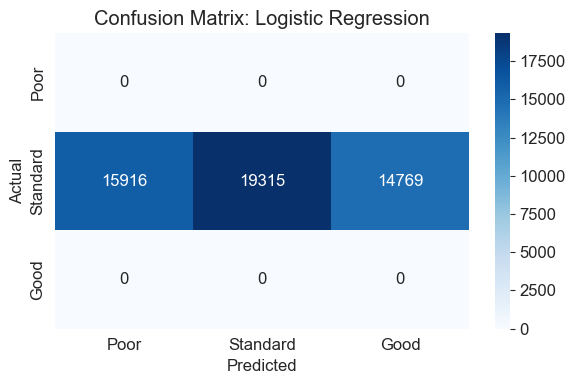

Classification Report:
              precision    recall  f1-score   support

        Poor       0.00      0.00      0.00         0
    Standard       1.00      0.39      0.56     50000
        Good       0.00      0.00      0.00         0

    accuracy                           0.39     50000
   macro avg       0.33      0.13      0.19     50000
weighted avg       1.00      0.39      0.56     50000


--- Random Forest ---
Test Accuracy: 0.4628


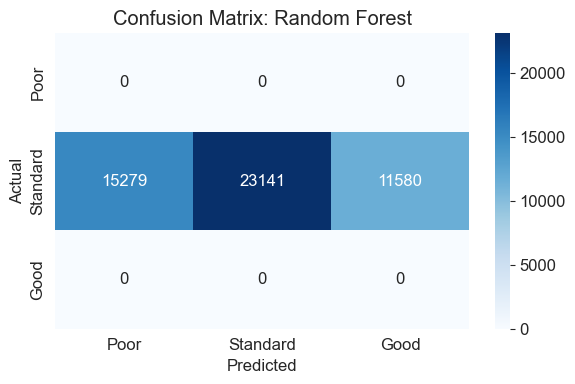

Classification Report:
              precision    recall  f1-score   support

        Poor       0.00      0.00      0.00         0
    Standard       1.00      0.46      0.63     50000
        Good       0.00      0.00      0.00         0

    accuracy                           0.46     50000
   macro avg       0.33      0.15      0.21     50000
weighted avg       1.00      0.46      0.63     50000


--- SVM ---
Test Accuracy: 0.3550


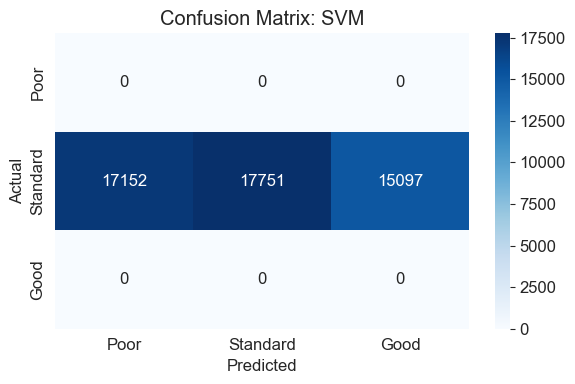

Classification Report:
              precision    recall  f1-score   support

        Poor       0.00      0.00      0.00         0
    Standard       1.00      0.36      0.52     50000
        Good       0.00      0.00      0.00         0

    accuracy                           0.36     50000
   macro avg       0.33      0.12      0.17     50000
weighted avg       1.00      0.36      0.52     50000


--- K-Nearest Neighbors ---
Test Accuracy: 0.4026


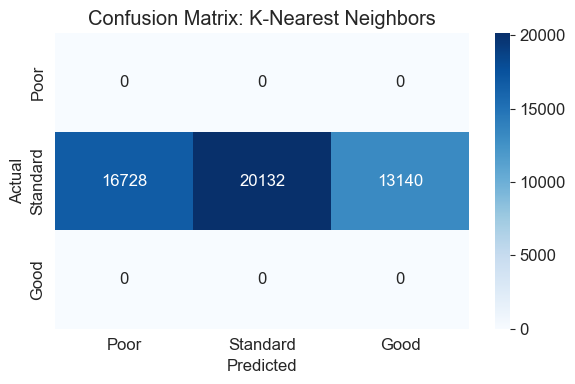

Classification Report:
              precision    recall  f1-score   support

        Poor       0.00      0.00      0.00         0
    Standard       1.00      0.40      0.57     50000
        Good       0.00      0.00      0.00         0

    accuracy                           0.40     50000
   macro avg       0.33      0.13      0.19     50000
weighted avg       1.00      0.40      0.57     50000


--- XGBoost ---
Test Accuracy: 0.4421


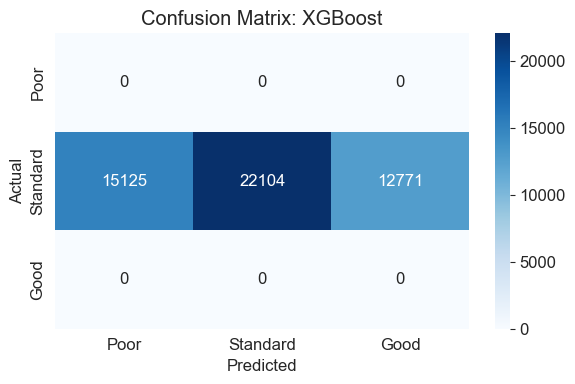

Classification Report:
              precision    recall  f1-score   support

        Poor       0.00      0.00      0.00         0
    Standard       1.00      0.44      0.61     50000
        Good       0.00      0.00      0.00         0

    accuracy                           0.44     50000
   macro avg       0.33      0.15      0.20     50000
weighted avg       1.00      0.44      0.61     50000


--- Model Accuracy Summary ---
Logistic Regression: 0.3863
Random Forest: 0.4628
SVM: 0.3550
K-Nearest Neighbors: 0.4026
XGBoost: 0.4421


In [50]:
# Model Evaluation and Visualization 
# with unseen test data (y_test) without cross validation so accuracy will differe in here
print("\n--- Evaluating Available Trained Models ---")

for model_name in models.keys():
    if model_name not in best_models:
        print(f"\n Skipping {model_name}: Training not completed.")
        continue

    print(f"\n--- {model_name} ---")

    # Predict and evaluate
    model = best_models[model_name]
    y_pred = model.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)
    model_accuracies[model_name] = accuracy

    print(f"Test Accuracy: {accuracy:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[credit_score_labels_map[i] for i in sorted(credit_score_labels_map)],
                yticklabels=[credit_score_labels_map[i] for i in sorted(credit_score_labels_map)])
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=[credit_score_labels_map[i] for i in sorted(credit_score_labels_map)]))

# Print summary
print("\n--- Model Accuracy Summary ---")
for model_name, acc in model_accuracies.items():
    print(f"{model_name}: {acc:.4f}")


--- Visualizing Model Accuracies ---


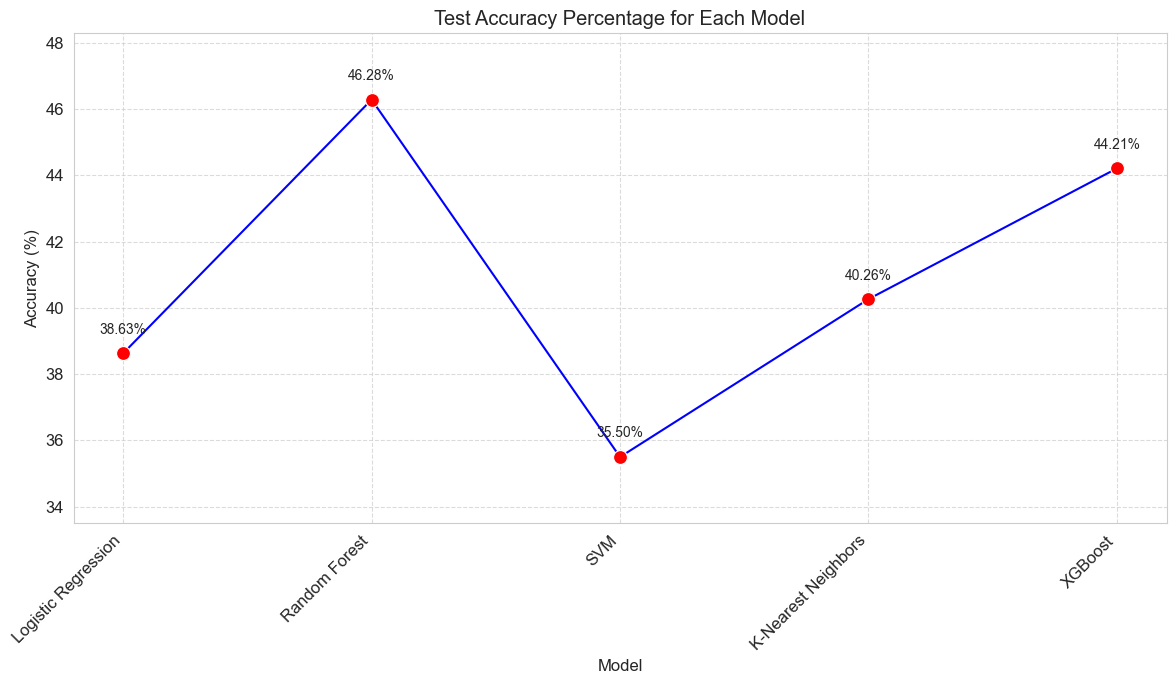

In [51]:
# Visualize Model Accuracies 
print("\n--- Visualizing Model Accuracies ---")
if model_accuracies:
    model_names = list(model_accuracies.keys())
    accuracies = [model_accuracies[name] * 100 for name in model_names] # Convert to percentage

    plt.figure(figsize=(12, 7))
    sns.lineplot(x=model_names, y=accuracies, marker='o', linestyle='-', color='blue')
    sns.scatterplot(x=model_names, y=accuracies, color='red', s=100, zorder=5) # Add points for clarity

    # Add text labels for accuracy percentages
    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 0.5, f'{acc:.2f}%', ha='center', va='bottom', fontsize=10)

    plt.title('Test Accuracy Percentage for Each Model')
    plt.xlabel('Model')
    plt.ylabel('Accuracy (%)')
    plt.ylim(min(accuracies) - 2, max(accuracies) + 2) # Adjust y-axis for better visibility
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("No model accuracies to display.")


--- Visualizing Test Accuracies ---


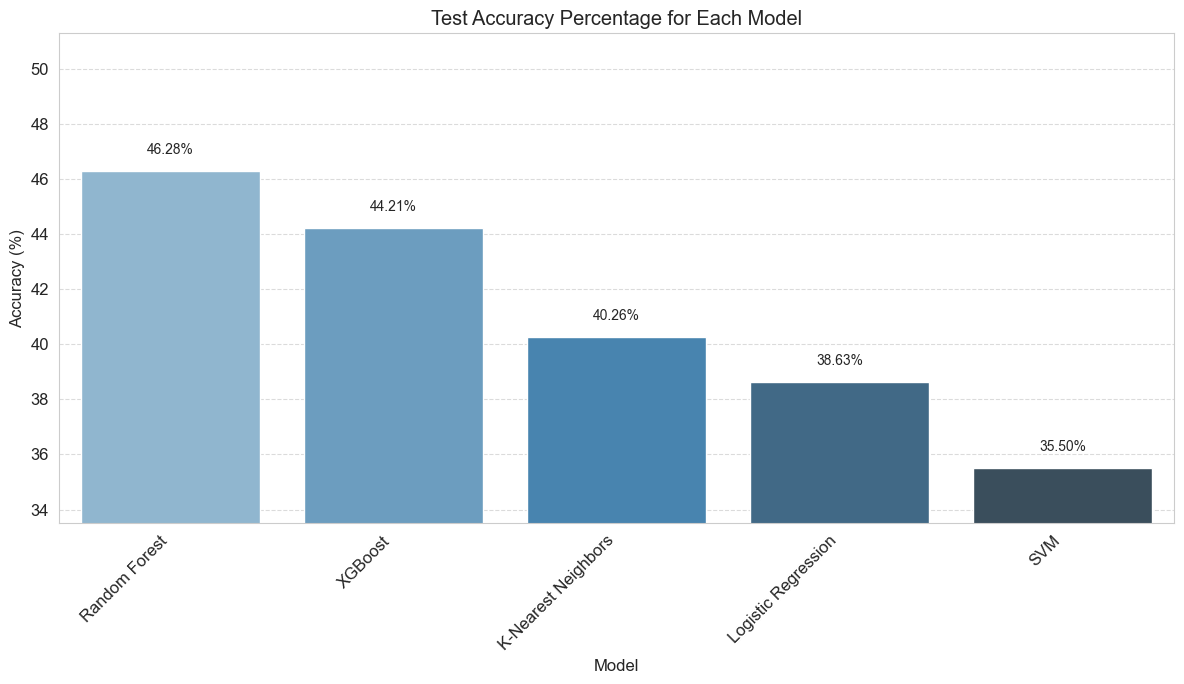

In [54]:
# Visualize Test Accuracies
print("\n--- Visualizing Test Accuracies ---")
if model_accuracies:
    sorted_items = sorted(model_accuracies.items(), key=lambda x: x[1], reverse=True)
    model_names, accuracies = zip(*[(k, v * 100) for k, v in sorted_items])  # Convert to percentage

    plt.figure(figsize=(12, 7))
    sns.barplot(x=model_names, y=accuracies, palette='Blues_d')
    
    # Add accuracy labels on bars
    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 0.5, f'{acc:.2f}%', ha='center', va='bottom', fontsize=10)

    plt.title('Test Accuracy Percentage for Each Model')
    plt.xlabel('Model')
    plt.ylabel('Accuracy (%)')
    plt.ylim(min(accuracies) - 2, max(accuracies) + 5)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("No model accuracies to display.")

In [58]:
# Determine the best model based on actual test set accuracy
best_overall_model_name = max(model_accuracies, key=model_accuracies.get)
best_overall_accuracy = model_accuracies[best_overall_model_name]
print(f"\n Best model based on test accuracy: {best_overall_model_name} ({best_overall_accuracy * 100:.2f}%)")


 Best model based on test accuracy: Random Forest (46.28%)


# Save and Load Best Model

In [64]:
# Save and Load and test on Best Model 
best_overall_model_name = max(model_accuracies, key=model_accuracies.get)
best_overall_accuracy = model_accuracies[best_overall_model_name]
print(f"\n Best model based on test accuracy: {best_overall_model_name} ({best_overall_accuracy * 100:.2f}%)")

print("\n--- Saving and Loading the Best Model ---")

if best_overall_model_name:
    best_model_to_save = best_models[best_overall_model_name]
    model_filename = f'best_credit_score_model_{best_overall_model_name.replace(" ", "_").lower()}.pkl'
    
    # Save the best model
    with open(model_filename, 'wb') as file:
        pickle.dump(best_model_to_save, file)
    print(f" Best model ({best_overall_model_name}) saved to '{model_filename}'.")

    # Save the selected features (optional, useful for deployment)
    with open('selected_features.pkl', 'wb') as f:
        pickle.dump(selected_features, f)
    print(" Selected features saved to 'selected_features.pkl'.")

    # Load the model
    with open(model_filename, 'rb') as file:
        loaded_model = pickle.load(file)
    print(f" Model loaded successfully from '{model_filename}'.")
    print(f"Loaded model type: {type(loaded_model)}")

    # Test on sample data
    if not X_test_selected.empty:
        print("\n--- Testing Loaded Model with Sample Data ---")
        num_samples_to_test = min(5, X_test_selected.shape[0])
        sample_data = X_test_selected.head(num_samples_to_test)
        actual_labels = y_test.head(num_samples_to_test).map(credit_score_labels_map)

        print(f"\nSample data (first {num_samples_to_test} rows from test set):\n{sample_data}")
    
        sample_predictions_encoded = loaded_model.predict(sample_data)
        sample_predictions_labels = pd.Series(sample_predictions_encoded).map(credit_score_labels_map)

        print(f"\nPredictions for sample data:")
        for i in range(num_samples_to_test):
            print(f"  Sample {i+1}: Predicted = {sample_predictions_labels.iloc[i]}, Actual = {actual_labels.iloc[i]}")
    else:
        print("Test set is empty. Cannot generate predictions.")
else:
    print("No best model found based on test accuracy.")


 Best model based on test accuracy: Random Forest (46.28%)

--- Saving and Loading the Best Model ---
 Best model (Random Forest) saved to 'best_credit_score_model_random_forest.pkl'.
 Selected features saved to 'selected_features.pkl'.
 Model loaded successfully from 'best_credit_score_model_random_forest.pkl'.
Loaded model type: <class 'sklearn.ensemble._forest.RandomForestClassifier'>

--- Testing Loaded Model with Sample Data ---

Sample data (first 5 rows from test set):
           Month       Age  Occupation  Annual_Income  Monthly_Inhand_Salary  \
100000  2.562727 -0.125057    0.964732      -0.107481              -0.744165   
100001  2.183063 -0.123570    0.964732      -0.107481              -0.744165   
100002  1.803400 -0.123570    0.964732      -0.107481              -0.744165   
100003 -0.854242 -0.110184    0.964732      -0.107481              -0.316623   
100004  2.562727 -0.117621    1.611246      -0.096179              -0.334524   

        Interest_Rate  Num_of_Loan  D

# Conclusion

###### From GridSearch cross validation highest accuracy found in the model RandomForest, which is approximate 82% on train data
###### But from the model evaluation stage the RandomForest also got highest accuracy on test or unseen data, which is 46.28%.
###### To avoid computational time I dropped the type_of_loan column, which creates 18 more column if I perform multi hot encoding because it is 
###### considered to be the most complex column. I also used oridinal encoding to all other catagorical column for keeping simplicity.
###### Implementing one hot encoding to all other categorcal colimn will extend features and increase computational complexity, which will be very
###### difficult for me to manage under my personal laptop. I beleive, performing one hot encoding will increase the models accuracy a lot more.